In [1]:
import pandas as pd
import numpy as np
import os
import shap
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


🔁 Cross-validation for label: Valence_Cat

Fold 1

Fold 2

Fold 3

Fold 4

Fold 5
📊 SHAP for Random Forest
📊 SHAP summary saved: shap_outputs/Valence_Cat/SHAP_Valence_Cat_Random Forest.png
📊 SHAP for XGBoost
📊 SHAP summary saved: shap_outputs/Valence_Cat/SHAP_Valence_Cat_XGBoost.png
📊 SHAP for Decision Tree
📊 SHAP summary saved: shap_outputs/Valence_Cat/SHAP_Valence_Cat_Decision Tree.png
🌳 Visualizing Decision Tree...
🌳 Decision Tree saved: shap_outputs/Valence_Cat/DecisionTree_Valence_Cat.png

📈 Plotting ROC curve for Valence_Cat
📈 ROC curve saved to: roc_outputs/ROC_Valence_Cat.png


<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

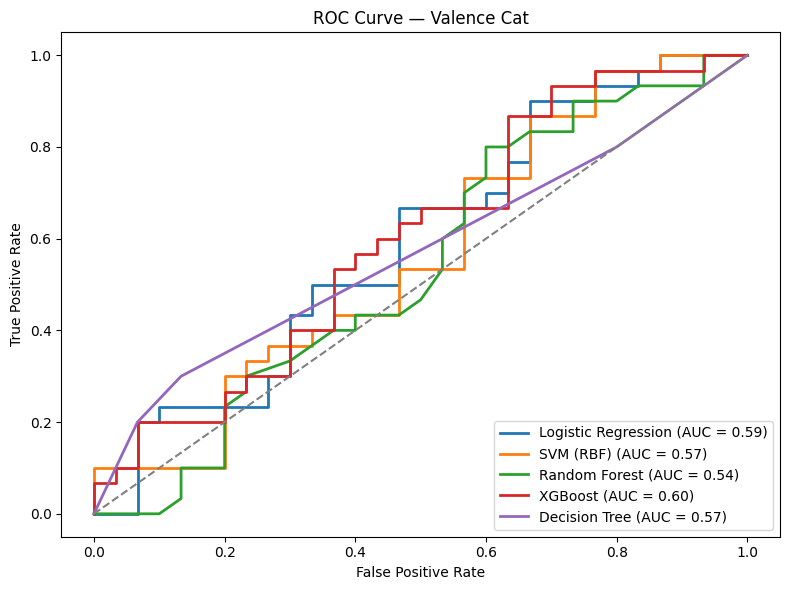


📊 Average Metrics Across Folds
                     Accuracy  Precision  Recall  F1 Score  ROC AUC
Logistic Regression    0.5950     0.5741  0.7489    0.6481   0.5950
SVM (RBF)              0.5900     0.5563  0.8622    0.6743   0.5900
Random Forest          0.5133     0.5053  0.5078    0.5017   0.5133
XGBoost                0.5261     0.5142  0.5478    0.5230   0.5261
Decision Tree          0.5444     0.5312  0.7800    0.6278   0.5444

⭐ Top 10 Intrinsic Features (from last fold only):

🔍 Logistic Regression
                              Feature  Importance
                      Peak Time Ratio     -1.1886
            Standard Deviation of GSR     -0.9708
           Area Under GSR Curve (AUC)      0.8429
Frequency Band Energy 0.0625–0.125 Hz      0.7873
                            GSR Slope     -0.6703
 Frequency Band Energy 0.1875–0.25 Hz      0.6518
                             Mean GSR     -0.6369
              Mean GSR Peak Amplitude      0.4936
Frequency Band Energy 0.3125–0.375 

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

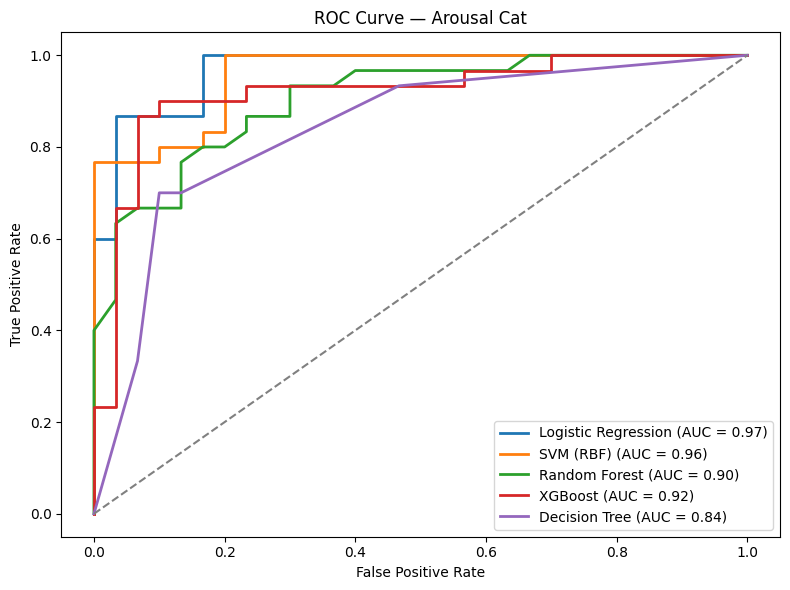


📊 Average Metrics Across Folds
                     Accuracy  Precision  Recall  F1 Score  ROC AUC
Logistic Regression    0.8467     0.8434  0.8556    0.8481   0.8467
SVM (RBF)              0.8183     0.8511  0.7811    0.8092   0.8183
Random Forest          0.8183     0.8128  0.8333    0.8197   0.8183
XGBoost                0.8622     0.8435  0.9000    0.8675   0.8622
Decision Tree          0.7606     0.7647  0.7733    0.7637   0.7606

⭐ Top 10 Intrinsic Features (from last fold only):

🔍 Logistic Regression
                             Feature  Importance
          Area Under GSR Curve (AUC)     -3.9252
                            Mean GSR      1.4435
             Mean GSR Peak Amplitude      1.1592
                           GSR Slope      1.0118
               Number of GSR Valleys     -0.8790
                   Minimum GSR Value      0.8235
                   Maximum GSR Value      0.7098
                 Number of GSR Peaks     -0.6713
Frequency Band Energy 0.25–0.3125 Hz      0.

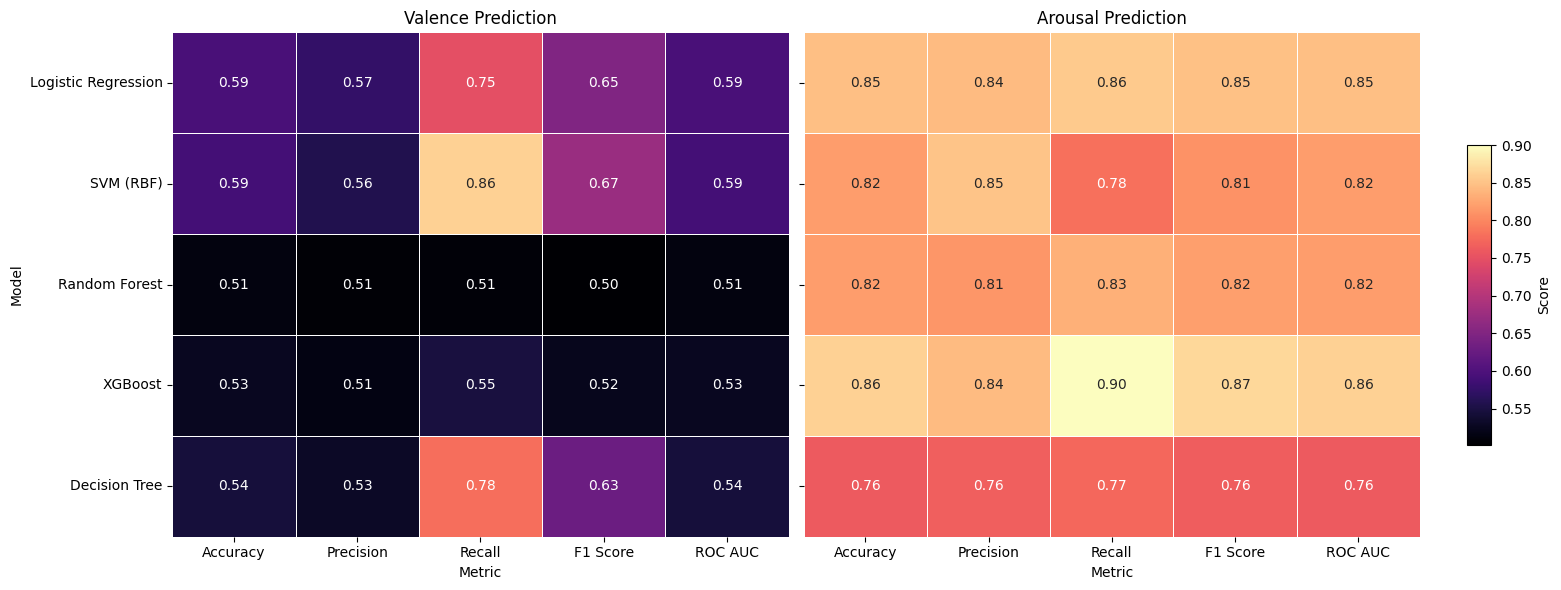

In [2]:
#dataset
df = pd.read_csv("/content/GSR_Wavelet_With_Labels.csv")

label_cols = ["label", "Valence_Cat", "Arousal_Cat", "participant", "video"]
feature_cols = [col for col in df.columns if col not in label_cols]

# Standardization
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Human-readable feature names
feature_name_map = {
    "GSR_Mean": "Mean GSR",
    "GSR_Std": "Standard Deviation of GSR",
    "GSR_Variance": "Variance of GSR",
    "GSR_Min": "Minimum GSR Value",
    "GSR_Max": "Maximum GSR Value",
    "GSR_Range": "GSR Range",
    "GSR_PeakCount": "Number of GSR Peaks",
    "GSR_ValleyCount": "Number of GSR Valleys",
    "GSR_PeakMeanAmp": "Mean GSR Peak Amplitude",
    "GSR_AUC": "Area Under GSR Curve (AUC)",
    "GSR_Slope": "GSR Slope",
    "GSR_PeakTimeRatio": "Peak Time Ratio",
    "freq0": "Frequency Band Energy 0–0.0625 Hz",
    "freq1": "Frequency Band Energy 0.0625–0.125 Hz",
    "freq2": "Frequency Band Energy 0.125–0.1875 Hz",
    "freq3": "Frequency Band Energy 0.1875–0.25 Hz",
    "freq4": "Frequency Band Energy 0.25–0.3125 Hz",
    "freq5": "Frequency Band Energy 0.3125–0.375 Hz",
    "freq6": "Frequency Band Energy 0.375–0.4375 Hz",
    "freq7": "Frequency Band Energy 0.4375–0.5 Hz"
}
full_feature_names = [feature_name_map.get(f, f) for f in feature_cols]

# Plot ROC curves
def plot_roc_curves(model_dict, X_test, y_test, label_col, output_dir="roc_outputs"):
    os.makedirs(output_dir, exist_ok=True)
    plt.figure(figsize=(8, 6))
    for name, model in model_dict.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
        else:
            continue
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {label_col.replace('_', ' ')}")
    plt.legend(loc="lower right")
    fname = os.path.join(output_dir, f"ROC_{label_col}.png")
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    print(f"📈 ROC curve saved to: {fname}")
    plt.show()

# Main function
def cross_val_models_with_shap(df, label_col, n_splits=5):
    print(f"\n🔁 Cross-validation for label: {label_col}")
    X = df[feature_cols].values
    y = df[label_col].values
    groups = df["participant"].values

    gkf = GroupKFold(n_splits=n_splits)
    model_names = ["Logistic Regression", "SVM (RBF)", "Random Forest", "XGBoost", "Decision Tree"]
    all_results = {name: [] for name in model_names}
    feature_importance_snapshot = {}
    os.makedirs(f"shap_outputs/{label_col}", exist_ok=True)

    for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
        print(f"\nFold {fold + 1}")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        models = {
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "SVM (RBF)": SVC(kernel='rbf', probability=True),
            "Random Forest": RandomForestClassifier(),
            "XGBoost": xgb.XGBClassifier(eval_metric='error', use_label_encoder=False),
            "Decision Tree": DecisionTreeClassifier(max_depth=4)
        }

        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            scores = [
                accuracy_score(y_test, y_pred),
                precision_score(y_test, y_pred, zero_division=0),
                recall_score(y_test, y_pred, zero_division=0),
                f1_score(y_test, y_pred, zero_division=0),
                roc_auc_score(y_test, y_pred)
            ]
            all_results[name].append(scores)

            if fold == n_splits - 1:
                # Intrinsic feature importances
                if name == "Logistic Regression":
                    feature_importance_snapshot[name] = model.coef_[0]
                elif name in ["Random Forest", "XGBoost", "Decision Tree"]:
                    feature_importance_snapshot[name] = model.feature_importances_

                # SHAP plots
                if name in ["Random Forest", "XGBoost", "Decision Tree"]:
                    print(f"📊 SHAP for {name}")
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_test)

                    plt.figure(figsize=(12, 9))
                    shap.summary_plot(shap_values, features=X_test,
                                      feature_names=full_feature_names, show=False)
                    shap_path = f"shap_outputs/{label_col}/SHAP_{label_col}_{name}.png"
                    plt.tight_layout()
                    plt.savefig(shap_path, dpi=300)
                    plt.close()
                    print(f"📊 SHAP summary saved: {shap_path}")

                # Decision Tree Plot
                if name == "Decision Tree":
                    print(f"🌳 Visualizing Decision Tree...")
                    plt.figure(figsize=(20, 10))
                    plot_tree(model, feature_names=full_feature_names,
                              filled=True, rounded=True, fontsize=10)
                    tree_path = f"shap_outputs/{label_col}/DecisionTree_{label_col}.png"
                    plt.tight_layout()
                    plt.savefig(tree_path, dpi=300)
                    plt.close()
                    print(f"🌳 Decision Tree saved: {tree_path}")

        if fold == n_splits - 1:
            print(f"\n📈 Plotting ROC curve for {label_col}")
            plot_roc_curves(models, X_test, y_test, label_col)

    # Print averaged metrics
    print("\n📊 Average Metrics Across Folds")
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
    model_results_df = pd.DataFrame({
        model: np.mean(scores, axis=0)
        for model, scores in all_results.items()
    }, index=metrics).T
    print(model_results_df.round(4).to_string())

    # Print top 10 features
    print("\n⭐ Top 10 Intrinsic Features (from last fold only):")

    def print_top_features(importances, model_name):
        sorted_idx = np.argsort(np.abs(importances))[::-1][:10]
        top_features = [full_feature_names[i] for i in sorted_idx]
        top_values = [importances[i] for i in sorted_idx]

        print(f"\n🔍 {model_name}")
        print(pd.DataFrame({
            "Feature": top_features,
            "Importance": np.round(top_values, 4)
        }).to_string(index=False))

    for model_name, importances in feature_importance_snapshot.items():
        print_top_features(importances, model_name)

    return model_results_df.round(4)

# Run for Valence and Arousal
valence_results = cross_val_models_with_shap(df, "Valence_Cat")
arousal_results = cross_val_models_with_shap(df, "Arousal_Cat")

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
vmin = min(valence_results.min().min(), arousal_results.min().min())
vmax = max(valence_results.max().max(), arousal_results.max().max())

sns.heatmap(valence_results, annot=True, cmap="magma", fmt=".2f",
            linewidths=0.5, vmin=vmin, vmax=vmax, cbar=False, ax=axes[0])
axes[0].set_title("Valence Prediction")
axes[0].set_ylabel("Model")
axes[0].set_xlabel("Metric")

sns.heatmap(arousal_results, annot=True, cmap="magma", fmt=".2f",
            linewidths=0.5, vmin=vmin, vmax=vmax, cbar=False, ax=axes[1])
axes[1].set_title("Arousal Prediction")
axes[1].set_xlabel("Metric")

cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
fig.colorbar(axes[1].collections[0], cax=cbar_ax, label='Score')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()
